# 4. Linear Regression

We will first build some regression models, starting with linear regression.

### Load the modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import metrics
import matplotlib.pyplot as plt

### Load dataset

In [2]:
# Read in dataset
devon_cornwall_lsoa = pd.read_csv('./data/dandc_crime_and_demographics.csv')
# Drop LSOA code
devon_cornwall = devon_cornwall_lsoa.drop('lsoa_code', axis=1)
# Make data float type
devon_cornwall = devon_cornwall.astype(float)

## Total crime

Let's first build a model to predict the total crime count in each LSOA. Please note that we will start off by using all of the available features, including race. We will discuss later what the models tell us and whether these features should be included. 

### Divide into features (X) and labels (y)

We will split into features (X) and labels (y) and convert these from pandas dataframes to NumPy arrays. These are simpler to refer to by row/column index numbers, which we will use for sklearn's k-fold method.

In [3]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['crime_total'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

### Standardise the data

Now we will write a function for standardising the data so that the features are on similar scales. We can use sklearn's StandardScaler method.

In [4]:
# Define function for standardising data
def standardise_data(X_train, X_test):   
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 
    # Set up the scaler just on the training set
    sc.fit(X_train)
    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

### Fit initial linear regression model

Let's define a function to fit an initial linear regression model, so that we can re-use it for other crime types.

In [5]:
# Define function for fitting initial linear regression model
def initial_linear_regression(X,y):
    # Set up lists to hold results for each k-fold run
    training_error_results = []
    test_error_results = []
    training_r2_results = []
    test_r2_results = []
    # Set up splits
    number_of_splits = 10
    seed = 42
    kf = KFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    kf.get_n_splits(X, y)
    # Loop through the k-fold splits
    for train_index, test_index in kf.split(X, y):
    
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]  
        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)   
        # Set up and fit model
        model = LinearRegression()
        model.fit(X_train_std,y_train)  
        # Predict training and test set labels
        y_pred_train = model.predict(X_train_std)
        y_pred_test = model.predict(X_test_std)   
        # Calculate RMSE and R-squared of training and test sets
        error_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
        error_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        # Add error to lists
        training_error_results.append(error_train)
        test_error_results.append(error_test)
        training_r2_results.append(r2_train)
        test_r2_results.append(r2_test)
        
    # Calculate mean training and test errors
    mean_training_error = np.mean(training_error_results)
    mean_test_error = np.mean(test_error_results)
    mean_training_r2 = np.mean(training_r2_results)
    mean_test_r2 = np.mean(test_r2_results)
        
    # Return mean training and test errors
    return mean_training_error, mean_test_error, mean_training_r2, mean_test_r2

In [6]:
initial_linear_regression(X,y)

(261.8947037930555, 416.3356204076713, 0.7876816352626101, 0.22746890559844654)

The mean value of total crime is 445, so the test error is a high RMSE. We can also see a big difference between the training and test mean R squared value. Let's try and improve on this.

### Feature selection

256 is a lot of features. Let's try univariate statistical selection to narrow down the number of features. This will allow us to expand to polynomial features afterwards (as 256 features creates nearly 33,000 polynomial features which is too many to handle easily!) We will use univariate statistical selection for efficiency - forwards or backwards elimination would take a long time with 256 features. 

Again, let's define a function so that we can re-use it for other crime types.

In [7]:
from scipy.stats.stats import pearsonr

# Define function to create dataframe of features' correlation and significance
def univariate_statistical_selection(X_df,y_df):

    features = list(X_df)
    correlation = []
    significance = []
    for feature in features:
        correl = pearsonr(X_df[feature].to_numpy(),y_df.to_numpy())
        correlation.append(correl[0])
        significance.append(correl[1])
    df = pd.DataFrame()
    df['feature'] = features
    df['correlation'] = correlation
    df['abs_correlation'] = np.abs(correlation)
    df['significance'] = significance
    df['significant'] = df['significance'] < 0.05 
    df.sort_values(by='abs_correlation', ascending=False, inplace=True)
    
    return df

In [8]:
df = univariate_statistical_selection(X_df,y_df)

In [9]:
# Look at head of dataframe
df.head()

feature  correlation  abs_correlation   significance  significant
26   room_rating     0.678509         0.678509  2.103269e-140         True
22          flat     0.663923         0.663923  2.087793e-132         True
23        owners    -0.598840         0.598840  1.236343e-101         True
2        married    -0.598149         0.598149  2.407553e-101         True
14  new_eu_birth     0.581820         0.581820   1.042276e-94         True

In [10]:
# Count how many features are significant
(df.significant == True).sum()

198

198 out of 256 features have been calculated as having a significant correlation with total crime number. This is still a very large number of features. Let's try and narrow this down further by visualising the effect of different numbers of features.

In [11]:
# Create list of ordered features
ordered_features = list(df['feature'])
# Create lists to store errors and R squared
error_by_feature_number = []
r2_by_feature_number = []
# Loop through feature list
number_of_features = len(ordered_features)
for i in range(number_of_features):
    
    features_to_use = ordered_features[0:i+1]
    X_selected = X_df[features_to_use]   
    # Convert dataframes to NumPy arrays
    X_np = X_selected.to_numpy()
    y_np = y_df.to_numpy()  
    # Run k fold model
    # Set up list to hold results for each k-fold run
    test_error_results = []
    test_r2_results = []
    # Set up splits
    number_of_splits = 10
    seed = 42
    kf = KFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    kf.get_n_splits(X_np, y_df)
    # Loop through the k-fold splits
    for train_index, test_index in kf.split(X_np, y_np):
        
        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_df[train_index], y_df[test_index]
        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        # Set up and fit model
        model = LinearRegression()
        model.fit(X_train_std,y_train)
        # Predict test set labels
        y_pred_test = model.predict(X_test_std)       
        # Calculate RMSE and R squared of test sets
        error_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
        r2_test = r2_score(y_test, y_pred_test)
        # Add to lists
        test_error_results.append(error_test)
        test_r2_results.append(r2_test)
        
    # Add mean error and R squared to records by feature number
    error_by_feature_number.append(np.mean(test_error_results))
    r2_by_feature_number.append(np.mean(test_r2_results))

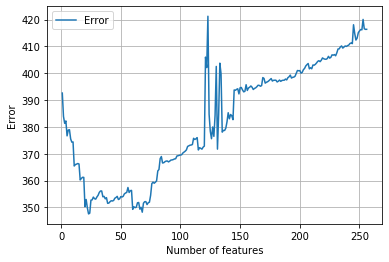

In [12]:
# Draw plot of error by number of features
%matplotlib inline

chart_x = list(range(1, number_of_features + 1))

plt.plot(chart_x, error_by_feature_number,
        label = 'Error')

plt.xlabel('Number of features')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.show()

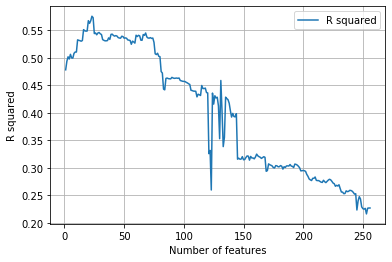

In [13]:
# Draw plot of R squared by number of features
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = list(range(1, number_of_features + 1))

plt.plot(chart_x, r2_by_feature_number,
        label = 'R squared')

plt.xlabel('Number of features')
plt.ylabel('R squared')
plt.legend()
plt.grid(True)

plt.show()

The first graph shows that the error reduces until around 20 features, and then begins to rise. The second graph shows that R squared is also highest at about 20 features. Taking the top 20 features is likely to give us our best model. What are the top 20 features? Let's define a function that will return these.

In [14]:
# Define function that will return top 20 features
def top_20_features(df):
    ordered_features = list(df['feature'])
    top_features = ordered_features[0:20]
    return top_features

In [15]:
# Look at top 20 features
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.678509         0.678509  2.103269e-140   
22                    flat     0.663923         0.663923  2.087793e-132   
23                  owners    -0.598840         0.598840  1.236343e-101   
2                  married    -0.598149         0.598149  2.407553e-101   
14            new_eu_birth     0.581820         0.581820   1.042276e-94   
12           british_birth    -0.545347         0.545347   3.610817e-81   
33           two_plus_cars    -0.522259         0.522259   2.010892e-73   
249                 idaopi     0.512114         0.512114   3.330307e-70   
1                   single     0.508691         0.508691   3.839501e-69   
36   alternative_transport     0.503965         0.503965   1.072790e-67   
243       employment_score     0.501370         0.501370   6.528502e-67   
4                    white    -0.500062         0.500062   1.613554e-66   
241                    imd     0.497972         0.497972   6.791897e-66   
24            private_rent     0.496369         0.496369   2.032332e-65   
35       private_transport    -0.491685         0.491685   4.828930e-64   
253         wider_barriers     0.490078         0.490078   1.416799e-63   
245           health_score     0.479136         0.479136   1.849066e-60   
242           income_score     0.473733         0.473733   5.813613e-59   
37            unemployment     0.470038         0.470038   5.931648e-58   
85                    m_27     0.466489         0.466489   5.375421e-57   

     significant  
26          True  
22          True  
23          True  
2           True  
14          True  
12          True  
33          True  
249         True  
1           True  
36          True  
243         True  
4           True  
241         True  
24          True  
35          True  
253         True  
245         True  
242         True  
37          True  
85          True

In [16]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('crime_total')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('crime_total',axis=1) 
y_df = feature_selected['crime_total'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

### Polynomial features
To allow for feature interaction, let's create new features which are the products of two features.

In [17]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [18]:
# Look at shape of the normal and expanded dataframes
print ('Shape of X:', X.shape)
print ('Shape of X_poly:', X_poly.shape)

Shape of X: (1034, 20)
Shape of X_poly: (1034, 210)


We now have 210 features. Let's test them.

In [19]:
# Set up splits
seed = 42
kf = KFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
kf.get_n_splits(X, y)
kf.get_n_splits(X_poly, y)

# Set up model type  
# Set up lists for results for each of k splits
training_k_results = []
test_k_results = []
training_k_results_poly = []
test_k_results_poly = []

training_r2_results = []
training_r2_results_poly = []
test_r2_results = []
test_r2_results_poly = []
# Loop through the k-fold splits
for train_index, test_index in kf.split(X, y):
        
    # Normal (non-polynomial model)       
    # Get X and Y train/test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    # Fit model 
    model = LinearRegression()
    model.fit(X_train_std,y_train)
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    # Calculate error and R squared of training and test sets
    error_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    error_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    # Record error for each k-fold split
    training_k_results.append(error_train)
    test_k_results.append(error_test)
    training_r2_results.append(r2_train)
    test_r2_results.append(r2_test)
        
    # Polynomial model (same as above except use X with polynomial features)       
    # Get X and Y train/test
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    # Fit model 
    model = LinearRegression()
    model.fit(X_train_std,y_train)
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    # Calculate error of training and test sets
    error_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    error_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    # Record error for each k-fold split
    training_k_results_poly.append(error_train)
    test_k_results_poly.append(error_test)
    training_r2_results_poly.append(r2_train)
    test_r2_results_poly.append(r2_test)
        
# Print average error for each k-fold split
print("The mean training error for the linear model is ",np.mean(training_k_results))
print("The mean test error for the linear model is ",np.mean(test_k_results))
print("The mean training R squared for the linear model is ",np.mean(training_r2_results))
print("The mean test R squared for the linear model is ",np.mean(test_r2_results))
print("The mean training error for the polynomial model is ",np.mean(training_k_results_poly))
print("The mean test error for the polynomial model is ",np.mean(test_k_results_poly))
print("The mean training R squared for the polynomial model is ",np.mean(training_r2_results_poly))
print("The mean test R squared for the polynomial model is ",np.mean(test_r2_results_poly))

The mean training error for the linear model is  350.327031396181
The mean test error for the linear model is  350.2125168447898
The mean training R squared for the linear model is  0.6201069440713872
The mean test R squared for the linear model is  0.5675684202300166
The mean training error for the polynomial model is  197.69560100233588
The mean test error for the polynomial model is  405.9433524614366
The mean training R squared for the polynomial model is  0.8788147628008808
The mean test R squared for the polynomial model is  0.2867471602299652


The training error and R squared value for the polynomial model look comparatively encouraging. Let's now define a function for performing feature selection from our expanded features. 

In [20]:
# Define function for performing feature selection from expanded features
def select_from_expanded_features(poly,X_poly,y):

    # Transfer polynomial X into a pandas dataframe 
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())
    # Create list to store errors, R squared and chosen features
    error_by_feature_number = []
    r2_by_feature_number = []
    chosen_features = []
    # Initialise chosen features list and run tracker
    available_features = list(poly.get_feature_names())
    run = 0
    number_of_features = len(list(X))
    # Loop through feature list to select next feature
    maximum_features_to_choose = 20
    for i in range(maximum_features_to_choose):

        # Track and print progress
        run += 1
        print ('Feature run {} of {}'.format(run, maximum_features_to_choose))  
        # Reset best feature and error
        best_result = 450
        best_feature = ''
        # Loop through available features
        for feature in available_features:

            # Create copy of already chosen features to avoid original being changed
            features_to_use = chosen_features.copy()
            # Create a list of features from features already chosen + 1 new feature
            features_to_use.append(feature)
            # Get data for features, and convert to NumPy array
            X_np = X_poly_df[features_to_use].values        
            # Set up lists to hold results for each selected features
            test_error_results = [] 
            test_r2_results = []
            # Set up dataframe to hold actual and predicted values
            pred_df = pd.DataFrame()
            # Set up k-fold training/test splits
            number_of_splits = 10
            seed = 42
            kf = KFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
            kf.get_n_splits(X_np, y)
    
            # Loop through the k-fold splits
            k_fold_count = 1
            for train_index, test_index in kf.split(X_np, y):            
                # Get X and Y train/test
                X_train, X_test = X_np[train_index], X_np[test_index]
                y_train, y_test = y[train_index], y[test_index]   
                # Get X and Y train/test
                X_train_std, X_test_std = standardise_data(X_train, X_test)   
                # Set up and fit model
                model = LinearRegression()
                model.fit(X_train_std,y_train)   
                # Predict test set labels
                y_pred_test = model.predict(X_test_std) 
                # Add actual and predicted values to dataframe
                d = {'actual': y_test, 'pred': y_pred_test, 'k': k_fold_count}
                df = pd.DataFrame(data=d)
                pred_df = pd.concat([pred_df, df])
                # Calculate error and R squared of test sets
                error_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
                r2_test = r2_score(y_test, y_pred_test)
                # Add to lists
                test_error_results.append(error_test)
                test_r2_results.append(r2_test)
                
                k_fold_count +=1
          
            # Get average result from all k-fold splits
            feature_error = np.mean(test_error_results)
            feature_r2 = np.mean(test_r2_results)
            # Update chosen feature and result if this feature is a new best
            if feature_error < best_result:
                best_result = feature_error
                r2 = feature_r2
                best_feature = feature
    
        # k-fold splits are complete    
        # Add mean error to record of error by feature number
        error_by_feature_number.append(best_result)
        r2_by_feature_number.append(r2)
        chosen_features.append(best_feature)
        available_features.remove(best_feature)

    # Put results in DataFrame
    results = pd.DataFrame()
    results['feature to add'] = chosen_features
    results['error'] = error_by_feature_number
    results['r2'] = r2_by_feature_number
    
    return results, pred_df

In [21]:
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [22]:
# Show error and R-squared results
results_and_pred[0]

feature to add       error        r2
0          x1 x19  365.263634  0.500150
1          x9 x10  316.317919  0.635748
2          x9 x14  307.796523  0.655142
3         x10 x17  304.990449  0.657934
4         x10 x19  303.118769  0.655341
5         x18 x19  301.846029  0.655311
6         x15 x19  299.828107  0.661185
7          x9 x18  298.539178  0.664126
8             x14  297.843424  0.665644
9           x1 x9  296.701569  0.667681
10         x1 x14  293.206460  0.675950
11          x1 x8  291.904680  0.678875
12         x8 x18  290.107749  0.680835
13         x1 x16  288.874314  0.684135
14        x16 x18  287.558909  0.684483
15         x6 x15  286.651763  0.686518
16         x3 x19  286.046982  0.688663
17          x3 x7  285.235285  0.689665
18          x2 x9  284.534984  0.691110
19        x16 x19  284.110887  0.692294

In [23]:
# Define function to draw plot of error by number of features
def plot_error(results_and_pred):
    # Draw plot of error by number of features
    %matplotlib inline

    chart_x = list(range(1, 21))

    plt.plot(chart_x, results_and_pred[0]['error'])

    plt.xlabel('Number of features')
    plt.ylabel('Error')
    plt.grid(True)

    plot = plt.show()
    
    return plot

In [24]:
# Define function to draw plot of R squared by number of features
def plot_r2(results_and_pred):
    # Draw plot of error by number of features
    %matplotlib inline

    chart_x = list(range(1, 21))

    plt.plot(chart_x, results_and_pred[0]['r2'])

    plt.xlabel('Number of features')
    plt.ylabel('R squared')
    plt.grid(True)

    plot = plt.show()
    
    return plot

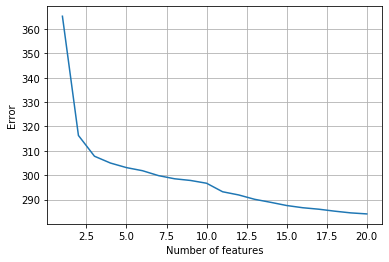

In [25]:
plot_error(results_and_pred)

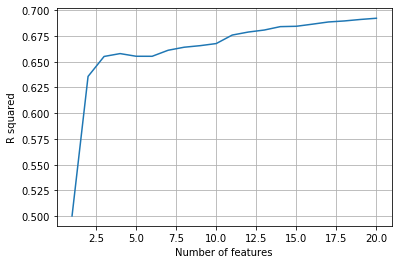

In [26]:
plot_r2(results_and_pred)

We can see that we have brought the test error down from an RMSE of 360 to 284 by selecting features from our expanded selection. The R squared value has increased from 0.5 to 0.69. This is still a high error, but the model has been optimised. 

### Plotting predicted and actual values

In [27]:
# Define function to plot predicted and actual values
def plot_actual_predicted(results_and_pred):
    groups = results_and_pred[1].groupby('k')
    
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.actual, group.pred, marker='.', linestyle='', ms=8, label=name)
    ax.legend(title = 'K fold')
    
    plt.xlabel('y actual')
    plt.ylabel('y predicted')
    plt.grid(True)

    plot = plt.show()
    
    return plot

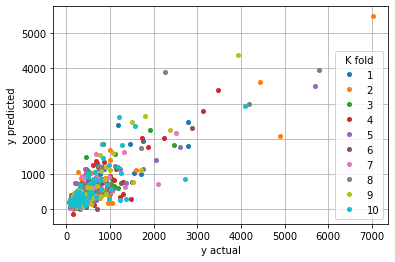

In [28]:
plot_actual_predicted(results_and_pred)

## Antisocial behaviour

Now let's build linear regression models for each crime type.

In [29]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['antisocial'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [30]:
initial_linear_regression(X,y)

(95.16222402236058,
 149.90969829332286,
 0.7515128656818412,
 0.10708403577987538)

With a mean antisocial behaviour value of 132, this test RMSE is also very high. Let's perform some feature selection and expansion, as we did for crime total.

In [31]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.655025         0.655025  9.545037e-128   
22                    flat     0.646473         0.646473  2.051566e-123   
23                  owners    -0.577222         0.577222   6.599588e-93   
2                  married    -0.572658         0.572658   3.799340e-91   
14            new_eu_birth     0.537473         0.537473   1.849425e-78   
33           two_plus_cars    -0.510502         0.510502   1.056365e-69   
12           british_birth    -0.500754         0.500754   1.000663e-66   
249                 idaopi     0.492994         0.492994   2.002829e-64   
243       employment_score     0.491299         0.491299   6.258823e-64   
241                    imd     0.482817         0.482817   1.704395e-61   
36   alternative_transport     0.479754         0.479754   1.242109e-60   
1                   single     0.473017         0.473017   9.139266e-59   
35       private_transport    -0.469222         0.469222   9.868045e-58   
24            private_rent     0.469172         0.469172   1.018163e-57   
253         wider_barriers     0.465865         0.465865   7.899285e-57   
245           health_score     0.464057         0.464057   2.398252e-56   
242           income_score     0.463365         0.463365   3.664340e-56   
4                    white    -0.453883         0.453883   1.099309e-53   
37            unemployment     0.450928         0.450928   6.269792e-53   
85                    m_27     0.435505         0.435505   4.218674e-49   

     significant  
26          True  
22          True  
23          True  
2           True  
14          True  
33          True  
12          True  
249         True  
243         True  
241         True  
36          True  
1           True  
35          True  
24          True  
253         True  
245         True  
242         True  
4           True  
37          True  
85          True

It is interesting that the top 20 features are similar to those calculated for crime total. Let's now do the polynomial expansion and selection.

In [32]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('antisocial')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('antisocial',axis=1) 
y_df = feature_selected['antisocial'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [33]:
# Show results
results_and_pred[0]

feature to add       error        r2
0          x1 x19  126.558007  0.454088
1           x0 x8  111.619513  0.597542
2          x0 x14  108.950244  0.614715
3         x14 x16  107.799471  0.623761
4          x8 x10  106.958435  0.628214
5           x1 x5  106.303827  0.631734
6          x1 x10  105.596357  0.635640
7         x10 x18  104.798296  0.638379
8          x2 x18  103.698945  0.645191
9          x1 x11  103.299422  0.646578
10         x8 x19  103.040454  0.646771
11         x3 x10  102.746704  0.648290
12          x7 x8  102.075964  0.645583
13        x18 x19  101.588329  0.648190
14        x17 x18  101.220006  0.649035
15         x5 x10  100.839912  0.650268
16          x5 x9  100.517719  0.651261
17          x7 x9  100.066172  0.656877
18         x5 x14   99.839537  0.659187
19          x0 x2   99.530081  0.660191

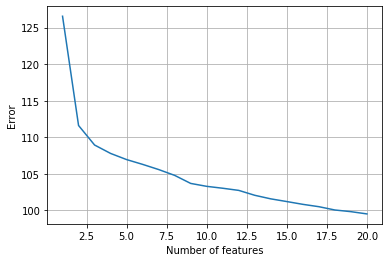

In [34]:
# Plot error
plot_error(results_and_pred)

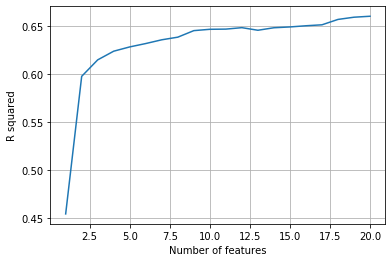

In [35]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen. 

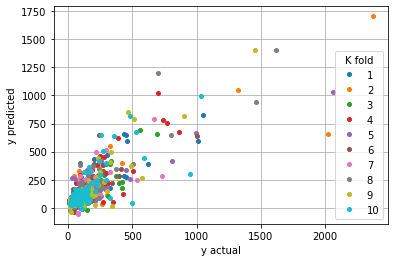

In [36]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Bike theft

In [37]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['bike_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [38]:
initial_linear_regression(X,y)

(3.4627115678707447,
 5.3615471886472905,
 0.7535839416519953,
 0.1279189782071537)

With a mean bike theft value of 2.6, this test RMSE is very high. Please note that the mean is very low, so this model may be of limited use.

In [39]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
9                  chinese     0.655846         0.655846  3.601011e-128   
4                    white    -0.628249         0.628249  1.241846e-114   
12           british_birth    -0.622855         0.622855  3.822809e-112   
83                    m_25     0.597160         0.597160  6.225877e-101   
84                    m_26     0.561469         0.561469   6.026515e-87   
85                    m_27     0.546796         0.546796   1.125302e-81   
11                    arab     0.534072         0.534072   2.601757e-77   
26             room_rating     0.533210         0.533210   5.060125e-77   
174                   f_24     0.516639         0.516639   1.258940e-71   
176                   f_26     0.506606         0.506606   1.678754e-68   
1                   single     0.506530         0.506530   1.770991e-68   
22                    flat     0.493194         0.493194   1.750115e-64   
80                    m_22     0.492082         0.492082   3.700275e-64   
2                  married    -0.490999         0.490999   7.652049e-64   
36   alternative_transport     0.490353         0.490353   1.178759e-63   
82                    m_24     0.488840         0.488840   3.231150e-63   
79                    m_21     0.487814         0.487814   6.386657e-63   
35       private_transport    -0.484700         0.484700   4.973523e-62   
173                   f_23     0.483226         0.483226   1.305123e-61   
175                   f_25     0.482007         0.482007   2.887262e-61   

     significant  
9           True  
4           True  
12          True  
83          True  
84          True  
85          True  
11          True  
26          True  
174         True  
176         True  
1           True  
22          True  
80          True  
2           True  
36          True  
82          True  
79          True  
35          True  
173         True  
175         True

In [40]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('bike_theft')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('bike_theft',axis=1) 
y_df = feature_selected['bike_theft'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [41]:
# Show results
results_and_pred[0]

feature to add     error        r2
0          x4 x11  4.310525  0.433541
1           x0 x5  3.759589  0.540965
2          x4 x17  3.714867  0.547989
3         x13 x14  3.700710  0.551588
4          x9 x13  3.690727  0.555208
5         x10 x13  3.690866  0.557231
6         x13 x19  3.691878  0.557048
7          x5 x19  3.689955  0.559823
8         x11 x13  3.685949  0.553895
9         x11 x14  3.680701  0.562676
10        x10 x19  3.667829  0.565900
11         x2 x19  3.637304  0.569005
12         x9 x17  3.628031  0.571772
13         x8 x14  3.617601  0.573604
14        x11 x12  3.594520  0.577329
15          x3 x7  3.541332  0.578598
16             x7  3.494389  0.582664
17         x8 x13  3.458251  0.587820
18        x11 x15  3.438783  0.576553
19         x9 x10  3.420201  0.585750

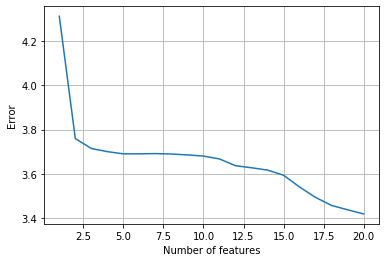

In [42]:
# Plot error
plot_error(results_and_pred)

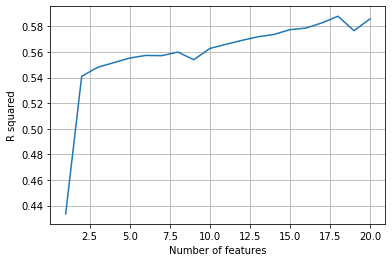

In [43]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen.

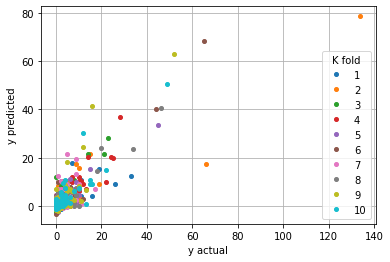

In [44]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Burglary

In [45]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['burglary'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [46]:
initial_linear_regression(X,y)

(7.823275361333849, 11.820557163668923, 0.752015513658937, 0.3155884954018121)

With a mean burglary value of 17.6, this test RMSE is high.

In [47]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
22                    flat     0.656066         0.656066  2.770749e-128   
26             room_rating     0.653744         0.653744  4.340037e-127   
14            new_eu_birth     0.600645         0.600645  2.153485e-102   
2                  married    -0.567055         0.567055   5.047325e-89   
24            private_rent     0.564346         0.564346   5.191605e-88   
23                  owners    -0.557935         0.557935   1.185243e-85   
12           british_birth    -0.549064         0.549064   1.792739e-82   
1                   single     0.499048         0.499048   3.245620e-66   
35       private_transport    -0.496197         0.496197   2.285400e-65   
4                    white    -0.482610         0.482610   1.950121e-61   
15                language     0.482574         0.482574   1.996693e-61   
241                    imd     0.474227         0.474227   4.252656e-59   
36   alternative_transport     0.471592         0.471592   2.241243e-58   
5                    mixed     0.468612         0.468612   1.442472e-57   
33           two_plus_cars    -0.464421         0.464421   1.918855e-56   
253         wider_barriers     0.464143         0.464143   2.275773e-56   
243       employment_score     0.452203         0.452203   2.963619e-53   
249                 idaopi     0.441504         0.441504   1.444686e-50   
174                   f_24     0.436981         0.436981   1.850884e-49   
83                    m_25     0.427347         0.427347   3.728660e-47   

     significant  
22          True  
26          True  
14          True  
2           True  
24          True  
23          True  
12          True  
1           True  
35          True  
4           True  
15          True  
241         True  
36          True  
5           True  
33          True  
253         True  
243         True  
249         True  
174         True  
83          True

In [48]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('burglary')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('burglary',axis=1) 
y_df = feature_selected['burglary'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [49]:
# Show results
results_and_pred[0]

feature to add      error        r2
0          x4 x11  11.100776  0.447016
1          x0 x19  10.155407  0.541332
2          x2 x16   9.861207  0.562345
3         x16 x18   9.736514  0.569281
4           x7 x8   9.596342  0.578142
5          x1 x19   9.542584  0.583512
6          x8 x19   9.511090  0.586823
7         x11 x15   9.499245  0.588414
8          x2 x19   9.481286  0.589931
9         x15 x19   9.476866  0.590642
10         x8 x17   9.473046  0.590154
11          x3 x4   9.462609  0.589969
12         x2 x14   9.447939  0.590784
13         x0 x15   9.433871  0.592507
14         x5 x17   9.428029  0.592501
15         x1 x11   9.420213  0.593319
16         x4 x14   9.405422  0.594332
17        x11 x14   9.402712  0.594620
18          x4 x5   9.404379  0.594527
19         x5 x11   9.397935  0.595812

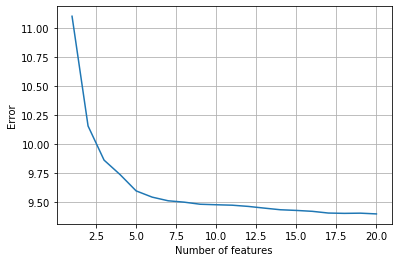

In [50]:
# Plot error
plot_error(results_and_pred)

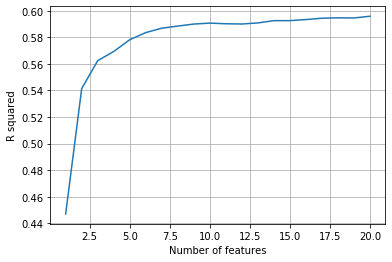

In [51]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen.

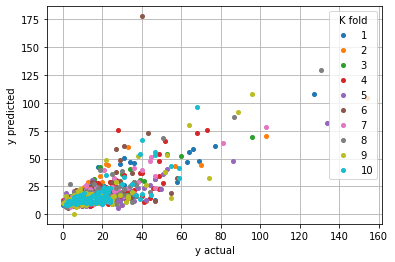

In [52]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Criminal damage and arson

In [53]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['damage_arson'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [54]:
initial_linear_regression(X,y)

(17.935831959126745,
 27.48986353241898,
 0.8128367369737578,
 0.45253029445585524)

With a mean criminal damage and arson value of 44.2, this test RMSE is high.

In [55]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.710482         0.710482  1.139078e-159   
22                    flat     0.681795         0.681795  2.861290e-142   
23                  owners    -0.677076         0.677076  1.345701e-139   
2                  married    -0.669583         0.669583  1.865773e-135   
33           two_plus_cars    -0.609951         0.609951  2.197185e-106   
249                 idaopi     0.608243         0.608243  1.213930e-105   
243       employment_score     0.595193         0.595193  4.083143e-100   
241                    imd     0.588789         0.588789   1.705316e-97   
253         wider_barriers     0.585861         0.585861   2.574330e-96   
14            new_eu_birth     0.582579         0.582579   5.220701e-95   
242           income_score     0.580516         0.580516   3.400547e-94   
1                   single     0.561073         0.561073   8.427469e-87   
37            unemployment     0.558362         0.558362   8.283252e-86   
245           health_score     0.555355         0.555355   1.019756e-84   
36   alternative_transport     0.533387         0.533387   4.415548e-77   
248                  idaci     0.522819         0.522819   1.326487e-73   
24            private_rent     0.521058         0.521058   4.900435e-73   
19                detached    -0.520263         0.520263   8.818886e-73   
12           british_birth    -0.514564         0.514564   5.689263e-71   
35       private_transport    -0.507395         0.507395   9.614952e-69   

     significant  
26          True  
22          True  
23          True  
2           True  
33          True  
249         True  
243         True  
241         True  
253         True  
14          True  
242         True  
1           True  
37          True  
245         True  
36          True  
248         True  
24          True  
19          True  
12          True  
35          True

In [56]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('damage_arson')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('damage_arson',axis=1) 
y_df = feature_selected['damage_arson'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [57]:
# Show results
results_and_pred[0]

feature to add      error        r2
0           x0 x6  26.295501  0.560365
1          x9 x14  24.971018  0.596872
2           x2 x3  24.476759  0.614242
3          x9 x11  24.289568  0.617111
4           x1 x9  24.127818  0.621668
5          x6 x11  24.001354  0.626367
6           x6 x8  23.859733  0.632144
7          x5 x16  23.781855  0.635330
8           x5 x6  23.742146  0.635829
9         x11 x16  23.649801  0.637056
10          x5 x8  23.597357  0.638504
11         x8 x10  23.561471  0.639294
12        x11 x19  23.539031  0.640203
13          x4 x5  23.509695  0.641727
14          x8 x9  23.498743  0.642236
15         x4 x13  23.492874  0.642673
16         x3 x13  23.419172  0.643626
17             x8  23.375336  0.645623
18        x14 x16  23.364604  0.646339
19         x1 x12  23.359981  0.647226

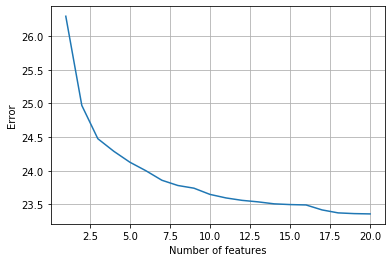

In [58]:
# Plot error
plot_error(results_and_pred)

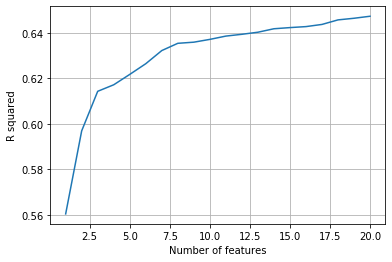

In [59]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen.

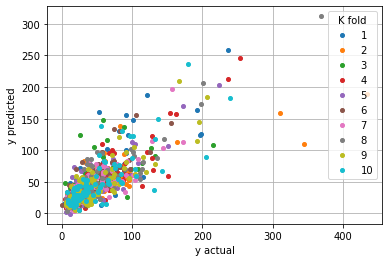

In [60]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Drugs

In [61]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['drugs'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [62]:
initial_linear_regression(X,y)

(13.06565640661521,
 20.830713814872205,
 0.7397898828128211,
 -0.6496475746540191)

With a mean drugs value of 12, this test RMSE is very high.

In [63]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26            room_rating     0.620706         0.620706  3.633727e-111   
22                   flat     0.588014         0.588014   3.507031e-97   
12          british_birth    -0.564551         0.564551   4.354722e-88   
4                   white    -0.527166         0.527166   5.093400e-75   
14           new_eu_birth     0.525626         0.525626   1.625303e-74   
2                 married    -0.509642         0.509642   1.951081e-69   
23                 owners    -0.489356         0.489356   2.292193e-63   
9                 chinese     0.485479         0.485479   2.983061e-62   
11                   arab     0.468917         0.468917   1.193451e-57   
1                  single     0.462117         0.462117   7.843279e-56   
36  alternative_transport     0.460076         0.460076   2.703947e-55   
83                   m_25     0.459642         0.459642   3.514315e-55   
13           old_eu_birth     0.453372         0.453372   1.487495e-53   
35      private_transport    -0.452318         0.452318   2.769467e-53   
85                   m_27     0.450786         0.450786   6.814719e-53   
5                   mixed     0.448354         0.448354   2.817637e-52   
15               language     0.436527         0.436527   2.385711e-49   
24           private_rent     0.428849         0.428849   1.649635e-47   
87                   m_29     0.427417         0.427417   3.590862e-47   
84                   m_26     0.418735         0.418735   3.709367e-45   

    significant  
26         True  
22         True  
12         True  
4          True  
14         True  
2          True  
23         True  
9          True  
11         True  
1          True  
36         True  
83         True  
13         True  
35         True  
85         True  
5          True  
15         True  
24         True  
87         True  
84         True

In [64]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('drugs')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('drugs',axis=1) 
y_df = feature_selected['drugs'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [65]:
# Show results
results_and_pred[0]

feature to add      error        r2
0          x1 x14  15.973865  0.320146
1         x14 x17  15.324821  0.387129
2           x0 x4  14.963017  0.419011
3          x1 x13  14.652832  0.429649
4         x10 x18  14.391945  0.472153
5         x13 x17  14.140193  0.496807
6           x4 x9  13.884796  0.524327
7         x10 x14  13.805026  0.522749
8         x10 x13  13.766141  0.526472
9          x6 x10  13.685031  0.526909
10         x0 x13  13.624139  0.530727
11          x3 x5  13.598364  0.532051
12          x3 x6  13.537195  0.535699
13          x3 x9  13.497827  0.538243
14         x1 x10  13.465949  0.540474
15         x0 x17  13.213169  0.554888
16         x0 x11  13.166489  0.547292
17         x2 x17  13.091894  0.546693
18         x5 x17  13.007080  0.554725
19          x4 x6  12.901389  0.553576

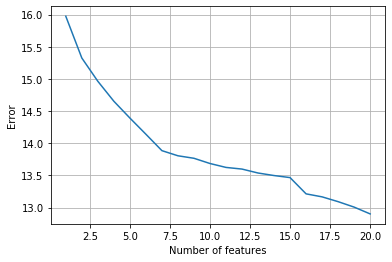

In [66]:
# Plot error
plot_error(results_and_pred)

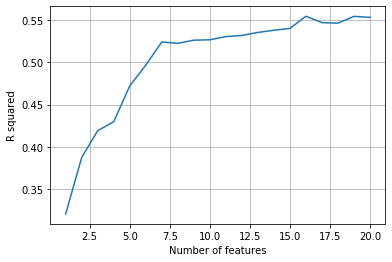

In [67]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen.

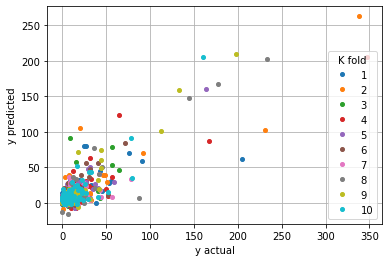

In [68]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Other crime

In [69]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [70]:
initial_linear_regression(X,y)

(5.830052980840914, 8.43042492998838, 0.6216195346861706, -0.29676341015003793)

With a mean other crime value of 6.7, this test RMSE is high. Please note that with such a low mean, this model may be of limited use.

In [71]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation  significance  significant
2          married    -0.408470         0.408470  7.509152e-43         True
91            m_33     0.391058         0.391058  4.053990e-39         True
4            white    -0.387302         0.387302  2.420986e-38         True
87            m_29     0.384431         0.384431  9.346751e-38         True
1           single     0.381300         0.381300  4.014019e-37         True
23          owners    -0.371530         0.371530  3.428969e-35         True
26     room_rating     0.369953         0.369953  6.930943e-35         True
84            m_26     0.369945         0.369945  6.955736e-35         True
12   british_birth    -0.366229         0.366229  3.596482e-34         True
5            mixed     0.350984         0.350984  2.432414e-31         True
22            flat     0.347844         0.347844  8.911444e-31         True
88            m_30     0.344814         0.344814  3.078090e-30         True
85            m_27     0.342947         0.342947  6.558005e-30         True
83            m_25     0.341471         0.341471  1.188818e-29         True
89            m_31     0.340338         0.340338  1.872608e-29         True
14    new_eu_birth     0.339636         0.339636  2.478877e-29         True
90            m_32     0.334274         0.334274  2.062834e-28         True
9          chinese     0.333303         0.333303  3.014343e-28         True
10           black     0.330224         0.330224  9.945707e-28         True
245   health_score     0.328661         0.328661  1.813444e-27         True

In [72]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('other_crime')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('other_crime',axis=1) 
y_df = feature_selected['other_crime'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [73]:
# Show results
results_and_pred[0]

feature to add     error        r2
0          x1 x10  6.891435  0.336872
1         x15 x19  6.733438  0.377107
2          x1 x11  6.558039  0.398154
3         x12 x19  6.526869  0.390958
4         x12 x17  6.515874  0.395182
5         x11 x12  6.491554  0.399634
6          x2 x10  6.482159  0.402287
7           x0 x3  6.472517  0.404985
8           x3 x6  6.467682  0.405707
9           x0 x1  6.454128  0.409308
10         x0 x12  6.445929  0.410142
11        x10 x16  6.447131  0.412878
12         x6 x10  6.445849  0.411603
13        x11 x16  6.443633  0.412700
14         x8 x16  6.430535  0.408728
15         x4 x10  6.426601  0.410278
16         x0 x10  6.411801  0.414561
17         x0 x19  6.401035  0.415204
18          x0 x4  6.401379  0.413809
19        x10 x11  6.402419  0.414137

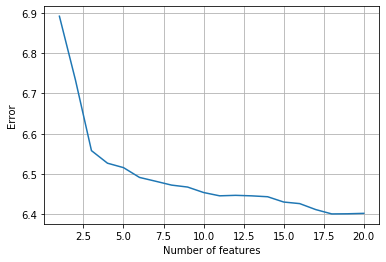

In [74]:
# Plot error
plot_error(results_and_pred)

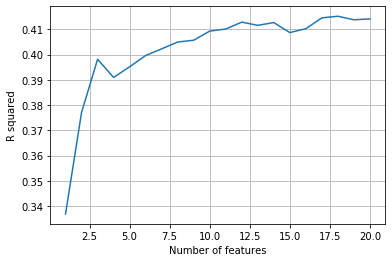

In [75]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen, although it is noticeably lower than other crime type models. 

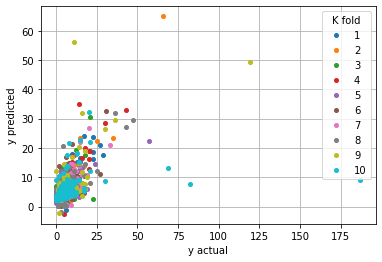

In [76]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Other theft

In [77]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [78]:
initial_linear_regression(X,y)

(21.182950109031516,
 33.04347190218779,
 0.7318714147208163,
 0.11246434657015514)

With a mean other theft value of 31.4, this test RMSE is high.

In [79]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.591702         0.591702  1.114373e-98   
22                    flat     0.572393         0.572393  4.798610e-91   
12           british_birth    -0.519745         0.519745  1.292147e-72   
14            new_eu_birth     0.503261         0.503261  1.752946e-67   
2                  married    -0.475083         0.475083  2.471071e-59   
23                  owners    -0.474741         0.474741  3.070244e-59   
4                    white    -0.460166         0.460166  2.560455e-55   
35       private_transport    -0.452957         0.452957  1.900685e-53   
9                  chinese     0.446267         0.446267  9.438416e-52   
36   alternative_transport     0.445666         0.445666  1.334848e-51   
83                    m_25     0.443856         0.443856  3.774777e-51   
24            private_rent     0.443371         0.443371  4.984809e-51   
85                    m_27     0.431941         0.431941  3.035526e-48   
176                   f_26     0.431155         0.431155  4.673683e-48   
1                   single     0.422751         0.422751  4.414286e-46   
84                    m_26     0.408517         0.408517  7.332207e-43   
174                   f_24     0.406070         0.406070  2.531495e-42   
175                   f_25     0.403027         0.403027  1.164661e-41   
11                    arab     0.399007         0.399007  8.541512e-41   
87                    m_29     0.397731         0.397731  1.598567e-40   

     significant  
26          True  
22          True  
12          True  
14          True  
2           True  
23          True  
4           True  
35          True  
9           True  
36          True  
83          True  
24          True  
85          True  
176         True  
1           True  
84          True  
174         True  
175         True  
11          True  
87          True

In [80]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('other_theft')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('other_theft',axis=1) 
y_df = feature_selected['other_theft'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [81]:
# Show results
results_and_pred[0]

feature to add      error        r2
0          x1 x12  29.223954  0.340995
1           x1 x9  28.580588  0.389492
2          x1 x14  28.093353  0.412873
3           x5 x9  27.424256  0.443874
4             x10  26.997551  0.460596
5         x11 x12  26.754285  0.472637
6          x4 x16  26.469738  0.485879
7          x0 x11  26.264335  0.494952
8           x7 x9  26.088537  0.502849
9           x1 x5  26.037646  0.505200
10         x4 x11  25.901146  0.511242
11         x5 x19  25.884237  0.512073
12         x7 x19  25.809493  0.515181
13        x14 x19  25.809599  0.512841
14          x4 x7  25.802712  0.512684
15             x5  25.768923  0.514813
16         x9 x15  25.762717  0.514210
17         x6 x19  25.775485  0.514278
18          x4 x9  25.778386  0.514511
19         x5 x11  25.743396  0.518059

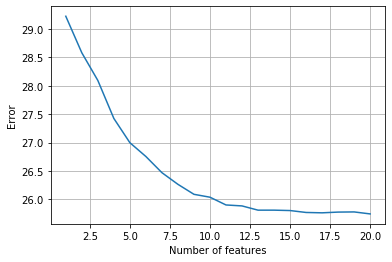

In [82]:
# Plot error
plot_error(results_and_pred)

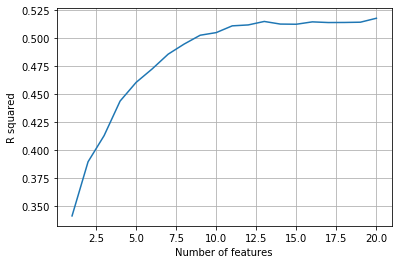

In [83]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen.

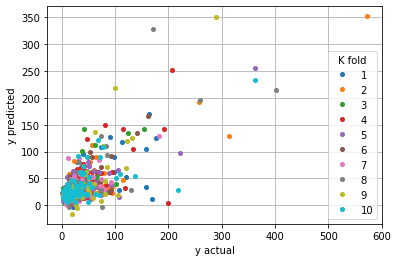

In [84]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Possession of weapons

In [85]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['possession_weapons'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [86]:
initial_linear_regression(X,y)

(3.0397430238969974,
 4.756663771996338,
 0.7114989657545767,
 -0.09532149735925213)

With a mean possession of weapons value of 2.8, this test RMSE is very high. Please note that with such a low mean, this model may be of limited use.

In [87]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.613401         0.613401  6.731801e-108   
22                    flat     0.596817         0.596817  8.653748e-101   
14            new_eu_birth     0.541000         0.541000   1.154481e-79   
23                  owners    -0.524532         0.524532   3.691654e-74   
2                  married    -0.521531         0.521531   3.451724e-73   
12           british_birth    -0.499207         0.499207   2.908193e-66   
249                 idaopi     0.471416         0.471416   2.502287e-58   
243       employment_score     0.462392         0.462392   6.633628e-56   
241                    imd     0.457502         0.457502   1.272729e-54   
4                    white    -0.456537         0.456537   2.267441e-54   
33           two_plus_cars    -0.452883         0.452883   1.985493e-53   
1                   single     0.445960         0.445960   1.126661e-51   
245           health_score     0.444778         0.444778   2.224691e-51   
36   alternative_transport     0.443068         0.443068   5.925749e-51   
37            unemployment     0.441760         0.441760   1.248801e-50   
24            private_rent     0.438417         0.438417   8.270943e-50   
15                language     0.437927         0.437927   1.089067e-49   
35       private_transport    -0.434160         0.434160   8.907567e-49   
253         wider_barriers     0.433517         0.433517   1.272171e-48   
242           income_score     0.428739         0.428739   1.751505e-47   

     significant  
26          True  
22          True  
14          True  
23          True  
2           True  
12          True  
249         True  
243         True  
241         True  
4           True  
33          True  
1           True  
245         True  
36          True  
37          True  
24          True  
15          True  
35          True  
253         True  
242         True

In [88]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('possession_weapons')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('possession_weapons',axis=1) 
y_df = feature_selected['possession_weapons'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [89]:
# Show results
results_and_pred[0]

feature to add     error        r2
0           x0 x7  3.931875  0.405177
1           x1 x2  3.703644  0.467855
2          x2 x15  3.645708  0.480151
3           x1 x4  3.609165  0.482062
4          x1 x13  3.549897  0.500927
5          x0 x11  3.465616  0.508190
6          x1 x10  3.435640  0.508559
7         x12 x13  3.418796  0.510332
8         x11 x17  3.408777  0.512811
9          x8 x19  3.393410  0.521519
10        x16 x18  3.389331  0.522809
11        x10 x18  3.383829  0.523373
12        x12 x18  3.381612  0.521978
13         x7 x18  3.375085  0.526836
14         x4 x13  3.371456  0.526884
15         x6 x10  3.368632  0.527112
16         x3 x18  3.364797  0.529217
17         x8 x12  3.362752  0.528124
18         x0 x17  3.361291  0.528301
19         x1 x18  3.358997  0.529364

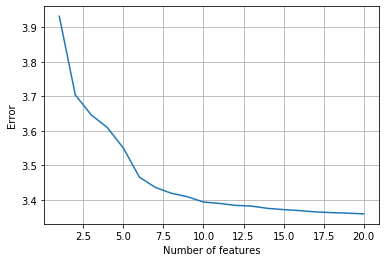

In [90]:
# Plot error
plot_error(results_and_pred)

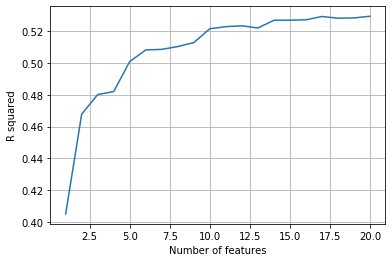

In [91]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen. 

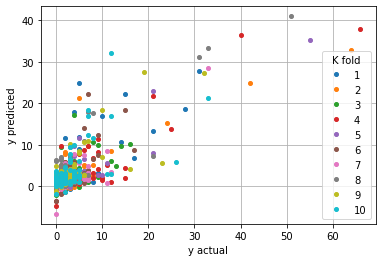

In [92]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Public order offences

In [93]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['public_order'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [94]:
initial_linear_regression(X,y)

(17.08728579865864, 26.822088983421747, 0.730471161252604, 0.12306903105985464)

With a mean public order offences value of 20.9, this test RMSE is very high.

In [95]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.618888         0.618888  2.408839e-110   
22                    flat     0.608787         0.608787  7.053342e-106   
23                  owners    -0.538376         0.538376   9.115417e-79   
2                  married    -0.536952         0.536952   2.778087e-78   
14            new_eu_birth     0.531763         0.531763   1.539235e-76   
12           british_birth    -0.520770         0.520770   6.064625e-73   
4                    white    -0.484069         0.484069   7.521223e-62   
33           two_plus_cars    -0.474692         0.474692   3.167293e-59   
36   alternative_transport     0.472963         0.472963   9.455367e-59   
35       private_transport    -0.465636         0.465636   9.099014e-57   
249                 idaopi     0.463118         0.463118   4.260629e-56   
1                   single     0.455484         0.455484   4.250017e-54   
9                  chinese     0.446356         0.446356   8.964949e-52   
243       employment_score     0.445830         0.445830   1.214772e-51   
24            private_rent     0.445239         0.445239   1.706926e-51   
241                    imd     0.439860         0.439860   3.665417e-50   
85                    m_27     0.433503         0.433503   1.282150e-48   
253         wider_barriers     0.431345         0.431345   4.210922e-48   
245           health_score     0.427389         0.427389   3.644724e-47   
5                    mixed     0.427183         0.427183   4.076526e-47   

     significant  
26          True  
22          True  
23          True  
2           True  
14          True  
12          True  
4           True  
33          True  
36          True  
35          True  
249         True  
1           True  
9           True  
243         True  
24          True  
241         True  
85          True  
253         True  
245         True  
5           True

In [96]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('public_order')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('public_order',axis=1) 
y_df = feature_selected['public_order'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [97]:
# Show results
results_and_pred[0]

feature to add      error        r2
0          x1 x16  22.297939  0.453669
1          x8 x13  20.404044  0.545698
2           x7 x9  19.983427  0.559761
3           x1 x7  19.835994  0.564500
4           x1 x8  19.683973  0.570044
5          x8 x11  19.412191  0.578275
6           x1 x5  19.361983  0.577807
7           x3 x8  19.242104  0.582190
8           x7 x8  19.094068  0.587779
9          x1 x11  18.984493  0.593871
10        x12 x18  18.926474  0.599329
11        x16 x18  18.829446  0.604619
12          x6 x7  18.773763  0.606069
13         x7 x12  18.748441  0.606290
14        x13 x16  18.731192  0.602365
15         x9 x16  18.591734  0.605831
16        x10 x13  18.534974  0.604824
17        x12 x13  18.482114  0.610741
18         x5 x11  18.451844  0.611505
19         x8 x16  18.439892  0.612368

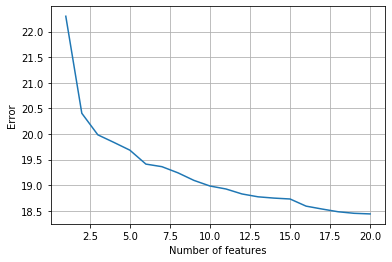

In [98]:
# Plot error
plot_error(results_and_pred)

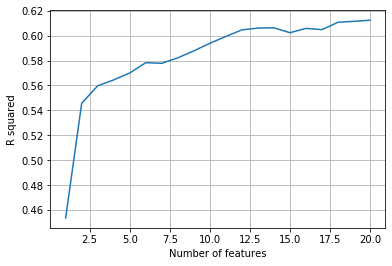

In [99]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen. 

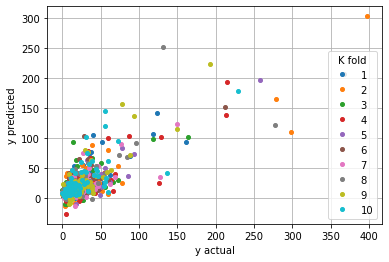

In [100]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Robbery

In [101]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['robbery'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [102]:
initial_linear_regression(X,y)

(2.5574785795825536,
 3.9133112778732597,
 0.7071395760987131,
 0.12374837303671996)

With a mean robbery value of 1.7, this test RMSE is very high. Please note that with such a low mean, this model may be of limited use.

In [103]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.626146         0.626146  1.175763e-113   
22                    flat     0.603580         0.603580  1.225992e-103   
14            new_eu_birth     0.577046         0.577046   7.724153e-93   
12           british_birth    -0.567803         0.567803   2.642611e-89   
4                    white    -0.527304         0.527304   4.587876e-75   
2                  married    -0.527075         0.527075   5.453632e-75   
23                  owners    -0.520593         0.520593   6.911343e-73   
15                language     0.493629         0.493629   1.304179e-64   
24            private_rent     0.493532         0.493532   1.392773e-64   
1                   single     0.487112         0.487112   1.016077e-62   
5                    mixed     0.476036         0.476036   1.347210e-59   
11                    arab     0.469399         0.469399   8.838551e-58   
35       private_transport    -0.460990         0.460990   1.554474e-55   
36   alternative_transport     0.454165         0.454165   9.302650e-54   
9                  chinese     0.450799         0.450799   6.762252e-53   
241                    imd     0.441546         0.441546   1.409919e-50   
249                 idaopi     0.437224         0.437224   1.615790e-49   
33           two_plus_cars    -0.432349         0.432349   2.423646e-48   
243       employment_score     0.429880         0.429880   9.396498e-48   
245           health_score     0.426974         0.426974   4.563892e-47   

     significant  
26          True  
22          True  
14          True  
12          True  
4           True  
2           True  
23          True  
15          True  
24          True  
1           True  
5           True  
11          True  
35          True  
36          True  
9           True  
241         True  
249         True  
33          True  
243         True  
245         True

In [104]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('robbery')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('robbery',axis=1) 
y_df = feature_selected['robbery'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [105]:
# Show results
results_and_pred[0]

feature to add     error        r2
0           x1 x2  3.046213  0.508188
1          x1 x19  2.894882  0.552832
2         x11 x14  2.801085  0.589604
3          x2 x12  2.772795  0.597510
4         x13 x18  2.746971  0.600453
5          x1 x12  2.693927  0.605461
6          x6 x12  2.672383  0.606387
7          x5 x18  2.652963  0.614249
8         x12 x13  2.637233  0.614310
9          x1 x17  2.628636  0.615683
10         x6 x17  2.619134  0.618929
11          x0 x7  2.608082  0.615742
12          x7 x9  2.594421  0.616775
13             x2  2.584656  0.620333
14         x6 x11  2.581416  0.621537
15         x5 x11  2.577234  0.607760
16         x0 x18  2.571844  0.611697
17         x5 x16  2.567995  0.612077
18          x2 x6  2.565005  0.613788
19        x12 x16  2.561462  0.614916

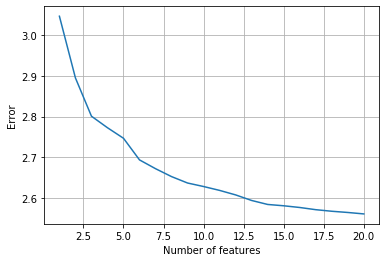

In [106]:
# Plot error
plot_error(results_and_pred)

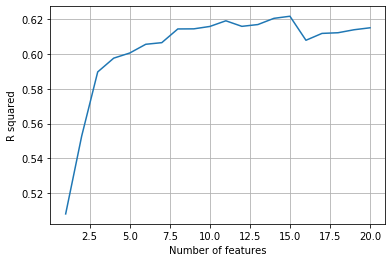

In [107]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen. It looks as though the optimal model might only need 15 features.

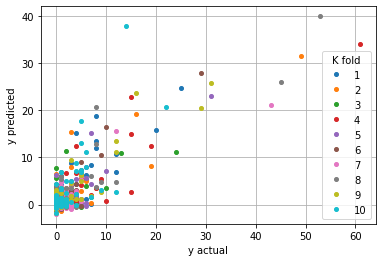

In [108]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Shoplifting

In [109]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['shoplifting'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [110]:
initial_linear_regression(X,y)

(48.299619750700934,
 74.51550294798166,
 0.5973885288902002,
 -0.4690313926502404)

With a mean shoplifting value of 23.2, this test RMSE is very high.

In [111]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation  significance  \
22                     flat     0.477869         0.477869  4.175138e-60   
26              room_rating     0.473032         0.473032  9.054607e-59   
14             new_eu_birth     0.413283         0.413283  6.371115e-44   
12            british_birth    -0.402731         0.402731  1.349750e-41   
2                   married    -0.396880         0.396880  2.424188e-40   
36    alternative_transport     0.392593         0.392593  1.939371e-39   
23                   owners    -0.382667         0.382667  2.128131e-37   
35        private_transport    -0.369180         0.369180  9.773021e-35   
24             private_rent     0.352541         0.352541  1.270512e-31   
13             old_eu_birth     0.350900         0.350900  2.519073e-31   
33            two_plus_cars    -0.349204         0.349204  5.088067e-31   
4                     white    -0.344369         0.344369  3.688212e-30   
1                    single     0.325003         0.325003  7.298303e-27   
5                     mixed     0.321813         0.321813  2.420121e-26   
249                  idaopi     0.321751         0.321751  2.476898e-26   
9                   chinese     0.321418         0.321418  2.804374e-26   
85                     m_27     0.319736         0.319736  5.242425e-26   
15                 language     0.314759         0.314759  3.259079e-25   
17   non_dependent_children    -0.307733         0.307733  4.054330e-24   
83                     m_25     0.307124         0.307124  5.029322e-24   

     significant  
22          True  
26          True  
14          True  
12          True  
2           True  
36          True  
23          True  
35          True  
24          True  
13          True  
33          True  
4           True  
1           True  
5           True  
249         True  
9           True  
85          True  
15          True  
17          True  
83          True

In [112]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('shoplifting')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('shoplifting',axis=1) 
y_df = feature_selected['shoplifting'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [113]:
# Show results
results_and_pred[0]

feature to add      error        r2
0           x0 x5  59.270411  0.156058
1          x0 x10  57.660116  0.149998
2          x5 x12  56.825578  0.166526
3         x14 x16  56.020925  0.194809
4           x0 x3  55.760111  0.199993
5           x0 x7  55.456188  0.214622
6          x0 x12  55.292876  0.237931
7           x0 x9  55.059898  0.253804
8           x4 x5  54.833907  0.260929
9           x5 x7  54.554872  0.260897
10         x5 x10  54.380935  0.269795
11         x9 x10  54.300866  0.270934
12        x10 x14  54.216113  0.275727
13         x5 x11  54.140273  0.280523
14        x15 x18  54.136406  0.281650
15         x6 x14  54.152523  0.281128
16        x10 x17  54.184426  0.280249
17        x14 x18  54.218440  0.279301
18         x0 x18  54.227202  0.284009
19          x5 x6  54.217077  0.276757

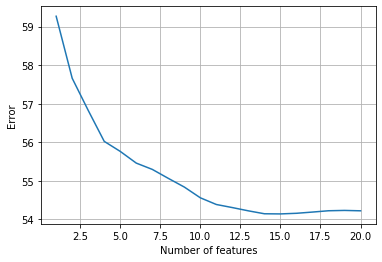

In [114]:
# Plot error
plot_error(results_and_pred)

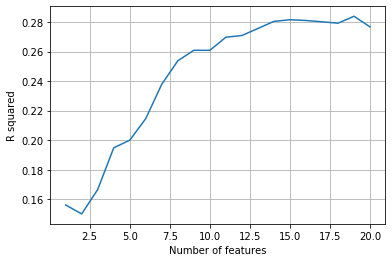

In [115]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen, but it is one of the lowest of the models. It looks as though the optimal model here might only need 15 features.

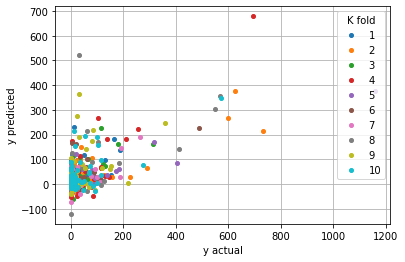

In [116]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Theft from the person

In [117]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['theft_person'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [118]:
initial_linear_regression(X,y)

(5.159392438761718, 8.34771407377965, 0.681218939325628, -0.9044568281091033)

With a mean theft from the person value of 2.6, this test RMSE is very high. Please note that with such a low mean, this model may be of limited use.

In [119]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.539311         0.539311  4.376677e-79   
22                    flat     0.535800         0.535800  6.815856e-78   
12           british_birth    -0.498108         0.498108  6.189383e-66   
14            new_eu_birth     0.484316         0.484316  6.399198e-62   
4                    white    -0.427048         0.427048  4.383872e-47   
2                  married    -0.419244         0.419244  2.837201e-45   
9                  chinese     0.412178         0.412178  1.126196e-43   
11                    arab     0.408953         0.408953  5.871551e-43   
24            private_rent     0.406744         0.406744  1.801111e-42   
35       private_transport    -0.406655         0.406655  1.883438e-42   
23                  owners    -0.404602         0.404602  5.296083e-42   
36   alternative_transport     0.399055         0.399055  8.342047e-41   
13            old_eu_birth     0.381787         0.381787  3.202895e-37   
85                    m_27     0.378856         0.378856  1.238670e-36   
83                    m_25     0.378419         0.378419  1.514183e-36   
5                    mixed     0.371997         0.371997  2.781451e-35   
1                   single     0.367914         0.367914  1.712085e-34   
84                    m_26     0.363604         0.363604  1.132987e-33   
33           two_plus_cars    -0.346445         0.346445  1.582095e-30   
17  non_dependent_children    -0.344491         0.344491  3.508703e-30   

    significant  
26         True  
22         True  
12         True  
14         True  
4          True  
2          True  
9          True  
11         True  
24         True  
35         True  
23         True  
36         True  
13         True  
85         True  
83         True  
5          True  
1          True  
84         True  
33         True  
17         True

In [120]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('theft_person')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('theft_person',axis=1) 
y_df = feature_selected['theft_person'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [121]:
# Show results
results_and_pred[0]

feature to add     error        r2
0          x1 x17  6.259478  0.226842
1          x8 x17  6.041020  0.286552
2          x1 x19  5.958236  0.299816
3          x1 x11  5.780284  0.351867
4          x8 x19  5.644844  0.386381
5          x6 x15  5.549980  0.399252
6          x1 x16  5.496387  0.414185
7          x5 x11  5.443111  0.426360
8          x6 x19  5.398291  0.433576
9          x9 x11  5.370055  0.438260
10         x6 x10  5.360050  0.435012
11        x11 x18  5.349024  0.435973
12        x16 x18  5.331791  0.437679
13        x14 x17  5.319883  0.444681
14          x5 x7  5.310098  0.446054
15         x3 x13  5.307892  0.436582
16         x3 x18  5.262207  0.447172
17        x10 x15  5.256194  0.444871
18        x13 x15  5.217877  0.438935
19         x6 x18  5.216393  0.436456

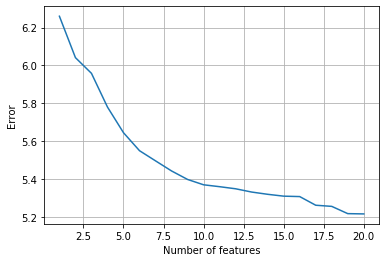

In [122]:
# Plot error
plot_error(results_and_pred)

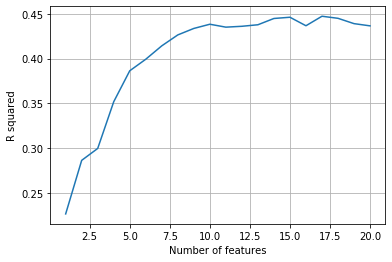

In [123]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen. 

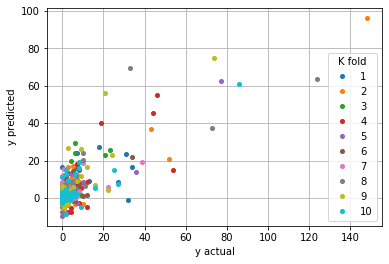

In [124]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Vehicle crime

In [125]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['vehicle_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [126]:
initial_linear_regression(X,y)

(7.400818093307516, 10.27014626485305, 0.6365225666571712, 0.2843520226931046)

With a mean vehicle crime value of 15.2, this test RMSE is high.

In [127]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation  significance  significant
14     new_eu_birth     0.479992         0.479992  1.064892e-60         True
22             flat     0.463035         0.463035  4.482621e-56         True
26      room_rating     0.460275         0.460275  2.397575e-55         True
255  outdoors_score     0.459342         0.459342  4.212108e-55         True
12    british_birth    -0.457186         0.457186  1.538259e-54         True
2           married    -0.454055         0.454055  9.928884e-54         True
1            single     0.448816         0.448816  2.153735e-52         True
24     private_rent     0.444551         0.444551  2.535526e-51         True
4             white    -0.428762         0.428762  1.729412e-47         True
5             mixed     0.417792         0.417792  6.088167e-45         True
10            black     0.393282         0.393282  1.391096e-39         True
85             m_27     0.389678         0.389678  7.837569e-39         True
86             m_28     0.388182         0.388182  1.595706e-38         True
87             m_29     0.382230         0.382230  2.608695e-37         True
19         detached    -0.379594         0.379594  8.824295e-37         True
174            f_24     0.377002         0.377002  2.893423e-36         True
15         language     0.374997         0.374997  7.200903e-36         True
176            f_26     0.373509         0.373509  1.410126e-35         True
91             m_33     0.369885         0.369885  7.142979e-35         True
83             m_25     0.363884         0.363884  1.003022e-33         True

In [128]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('vehicle_crime')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('vehicle_crime',axis=1) 
y_df = feature_selected['vehicle_crime'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [129]:
# Show results
results_and_pred[0]

feature to add      error        r2
0           x1 x7  10.555178  0.247041
1           x3 x4   9.901497  0.336885
2          x8 x18   9.605662  0.377013
3          x0 x15   9.549662  0.384454
4           x2 x6   9.478179  0.392885
5          x1 x14   9.438268  0.398199
6           x5 x6   9.405331  0.401786
7           x3 x7   9.383093  0.404357
8           x2 x7   9.361722  0.406558
9           x1 x4   9.321763  0.410474
10         x4 x17   9.307017  0.412462
11          x1 x5   9.293433  0.414185
12         x2 x14   9.281468  0.415306
13          x2 x4   9.270497  0.416775
14         x3 x14   9.250140  0.419590
15          x5 x9   9.241996  0.420404
16          x3 x8   9.231495  0.421997
17        x16 x19   9.224964  0.422453
18        x13 x14   9.220338  0.422261
19         x1 x18   9.207523  0.424178

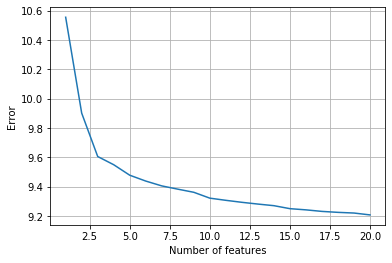

In [130]:
# Plot error
plot_error(results_and_pred)

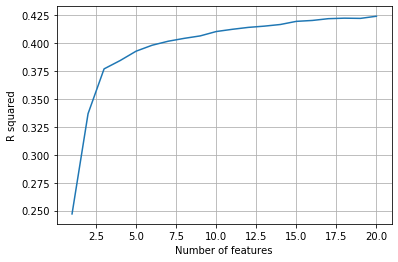

In [131]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen, but it is one of the lowest of the models.

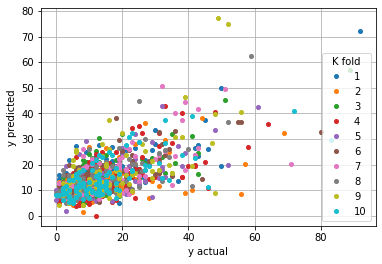

In [132]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)

## Violence and sexual offences

In [133]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['violence_sexual'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [134]:
initial_linear_regression(X,y)

(65.30365187963011,
 103.89818062950958,
 0.8036921144877969,
 0.31232138894472994)

With a mean violence and sexual offences value of 133, this test RMSE is high.

In [135]:
df = univariate_statistical_selection(X_df,y_df)
top_features = top_20_features(df)
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.678958         0.678958  1.173261e-140   
22                    flat     0.657081         0.657081  8.257496e-129   
23                  owners    -0.640606         0.640606  1.602492e-120   
2                  married    -0.620070         0.620070  7.055202e-111   
14            new_eu_birth     0.604286         0.604286  6.125998e-104   
243       employment_score     0.571151         0.571151   1.428275e-90   
241                    imd     0.570389         0.570389   2.784172e-90   
249                 idaopi     0.564899         0.564899   3.231920e-88   
33           two_plus_cars    -0.552169         0.552169   1.417494e-83   
242           income_score     0.547706         0.547706   5.393081e-82   
37            unemployment     0.545446         0.545446   3.336106e-81   
245           health_score     0.542356         0.542356   3.939032e-80   
253         wider_barriers     0.539591         0.539591   3.510559e-79   
1                   single     0.528905         0.528905   1.364003e-75   
12           british_birth    -0.524622         0.524622   3.449823e-74   
248                  idaci     0.503616         0.503616   1.369102e-67   
4                    white    -0.493826         0.493826   1.142135e-64   
24            private_rent     0.488329         0.488329   4.539078e-63   
36   alternative_transport     0.483486         0.483486   1.100945e-61   
87                    m_29     0.477156         0.477156   6.589323e-60   

     significant  
26          True  
22          True  
23          True  
2           True  
14          True  
243         True  
241         True  
249         True  
33          True  
242         True  
37          True  
245         True  
253         True  
1           True  
12          True  
248         True  
4           True  
24          True  
36          True  
87          True

In [136]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('violence_sexual')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('violence_sexual',axis=1) 
y_df = feature_selected['violence_sexual'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values
# Add polynomial features
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)
# Select features from expanded features
results_and_pred = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [137]:
# Show results
results_and_pred[0]

feature to add      error        r2
0           x0 x5  93.878708  0.527260
1          x1 x19  83.546199  0.629412
2         x15 x19  81.832539  0.644812
3          x5 x18  80.819243  0.653087
4           x0 x3  79.955530  0.659405
5          x9 x12  79.531018  0.662927
6          x2 x18  79.276992  0.666435
7          x3 x12  79.107528  0.668514
8          x9 x14  78.829093  0.667285
9          x0 x12  78.680249  0.667618
10          x1 x8  78.569011  0.668592
11         x1 x18  78.110804  0.673261
12             x1  77.673513  0.676680
13         x9 x18  77.141621  0.677177
14         x6 x12  76.980924  0.678453
15        x13 x18  76.845355  0.675661
16         x8 x12  76.754953  0.675310
17        x13 x15  76.622659  0.676722
18        x14 x15  76.547661  0.677830
19         x8 x18  76.556295  0.677609

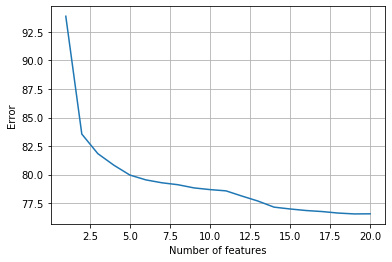

In [138]:
# Plot error
plot_error(results_and_pred)

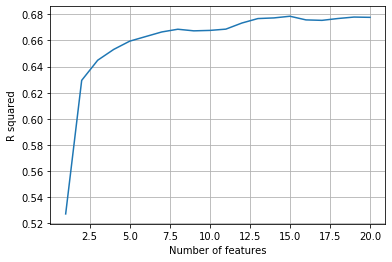

In [139]:
# Plot R squared
plot_r2(results_and_pred)

The test RMSE is still high, but lower than it was. R squared has risen.

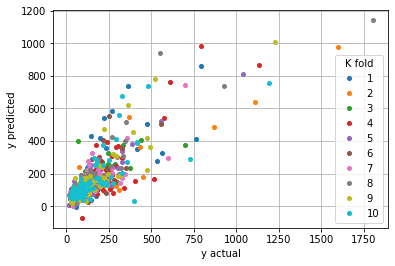

In [140]:
# Plot actual vs predicted values
plot_actual_predicted(results_and_pred)